# Molecular Tastants
Bogna Kilanowska 148252
https://www.kaggle.com/competitions/molecular-tastants

## Project setup
- load data
- load libs

In [1]:
import numpy as np 

np.random.seed(973)

In [2]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head()

,molecule_id,smiles,taste
0,train_0,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(OC1OC(C...,6
1,train_1,Nc1ccccc1NS(=O)(=O)[O-].[Na+],3
2,train_2,O=C1NS(=O)(=O)c2cc(O)ccc21,6
3,train_3,OCC1OC(Oc2ccc3ccccc3c2)C(O)C(O)C1O,0
4,train_4,CCC1(C2=CCCCCC2)C(=O)NC(=O)NC1=O,0


## Preliminary data analysis

In [3]:
df.shape

(1809, 3)

In [6]:
print("Na count:")
print(df.isna().sum())
print("NULL count:")
print(df.isnull().sum())

Na count:
molecule_id    0
smiles         0
taste          0
dtype: int64
NULL count:
molecule_id    0
smiles         0
taste          0
dtype: int64


taste
0    731
6    589
3    149
7    125
2     69
8     63
1     50
5     25
4      8
Name: count, dtype: int64


array([[<Axes: title={'center': 'taste'}>]], dtype=object)

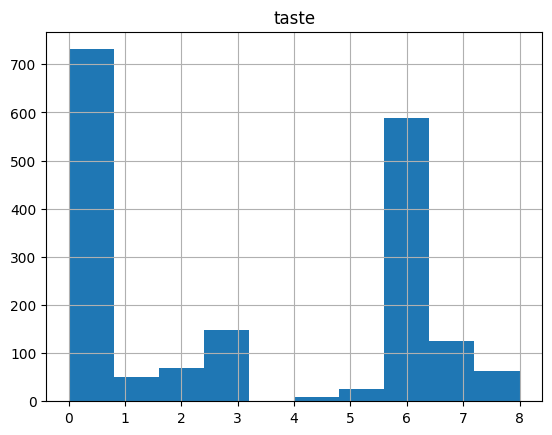

In [7]:
print(df.taste.value_counts())
df.hist(column='taste')

## Data pre-processing

### Data encoding

In [8]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem

def get_maccs_fps(df):

    maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in df.smiles]
    maccs_lists = [list(l) for l in maccs]
    maccs_name = [f'MACCS_{i}' for i in range(167)]
    X = pd.DataFrame(maccs_lists, index=df.index, columns=maccs_name)
    
    return X

### Data balancing

In [9]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter

def balance_classes(X, y):
    sme = SMOTE()

    print(f'Classes distribution : {sorted(Counter(y).items())}')
    X_resampled, y_resampled = sme.fit_resample(X, y)
    print(f'Classes distribution : {sorted(Counter(y_resampled).items())}')

    return X_resampled, y_resampled

### Feature engineering

In [53]:
from sklearn.feature_selection import VarianceThreshold

def select_features(df, threshold = 0.05):
    
    print(df.shape)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit_transform(df)
    print(df[df.columns[selector.get_support(indices=True)]].shape)

    return df[df.columns[selector.get_support(indices=True)]]

## Model training

### Train test split

In [10]:
from sklearn.model_selection import train_test_split

def train_test_split_data(X = df.smiles, y = df.taste):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
    print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

    return X_train, X_test, y_train, y_test 

### Model

In [25]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def train_model(X_train, y_train):

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)
    
    return clf

def make_prediction(clf, X_test):
    y_pred = clf.predict(X_test)

    return y_pred

def evaluate_model(y_test, y_pred, print_acc = True, show_cm = True, cm_labels = [0,1,2,3,4,5,6,7,8]):
    acc = balanced_accuracy_score(y_test, y_pred)

    if print_acc:
        print(f"Balanced accuracy: {acc:.2%}")

    if show_cm:
        cm = confusion_matrix(y_test, y_pred, labels = cm_labels)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8])
        cm_display.plot()
        plt.show()

    return acc



## Evaluation

### Case 01: model

Classes distribution train: [(0, 579), (1, 41), (2, 54), (3, 122), (4, 6), (5, 21), (6, 469), (7, 98), (8, 57)]
Classes distribution test: [(0, 152), (1, 9), (2, 15), (3, 27), (4, 2), (5, 4), (6, 120), (7, 27), (8, 6)]
Balanced accuracy: 42.76%


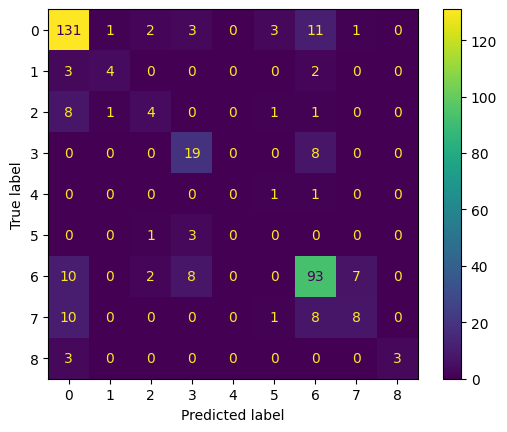

In [32]:
X = get_maccs_fps(df)
y = df.taste

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

clf = train_model(X_train, y_train)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

### Case 02 balancing data + model

Classes distribution train: [(0, 584), (1, 34), (2, 59), (3, 123), (4, 6), (5, 18), (6, 470), (7, 97), (8, 56)]
Classes distribution test: [(0, 147), (1, 16), (2, 10), (3, 26), (4, 2), (5, 7), (6, 119), (7, 28), (8, 7)]
Classes distribution : [(0, 584), (1, 34), (2, 59), (3, 123), (4, 6), (5, 18), (6, 470), (7, 97), (8, 56)]
Classes distribution : [(0, 584), (1, 584), (2, 584), (3, 584), (4, 584), (5, 584), (6, 584), (7, 584), (8, 584)]
Balanced accuracy: 56.51%


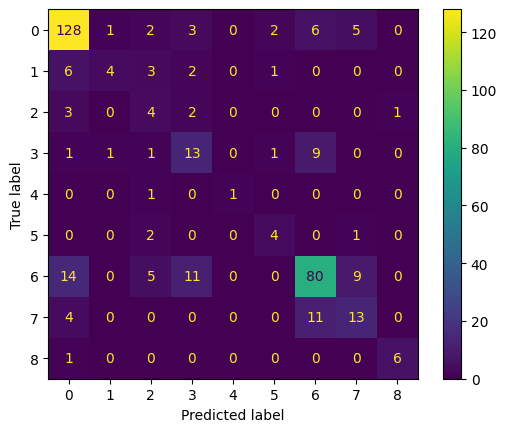

In [34]:
X = get_maccs_fps(df)
y = df.taste

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

X_resampled, y_resampled = balance_classes(X_train, y_train)

clf = train_model(X_resampled, y_resampled)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

### Case 03: feature engineering + model

Classes distribution train: [(0, 577), (1, 37), (2, 51), (3, 119), (4, 6), (5, 20), (6, 479), (7, 107), (8, 51)]
Classes distribution test: [(0, 154), (1, 13), (2, 18), (3, 30), (4, 2), (5, 5), (6, 110), (7, 18), (8, 12)]
(1447, 167)
(1447, 105)
Balanced accuracy: 51.26%


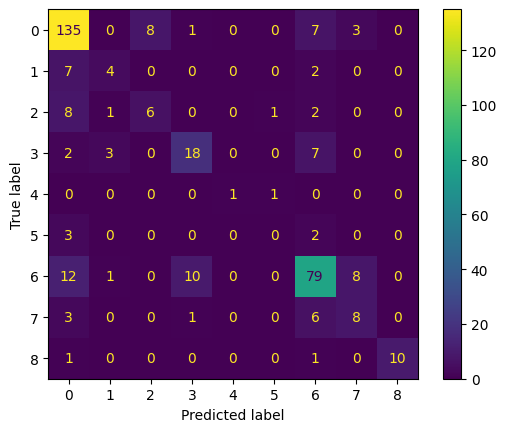

In [54]:
X = get_maccs_fps(df)
y = df.taste

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

X_selected = select_features(pd.DataFrame(X_train), threshold = 0.1)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_train)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

### Case 04: balancing data + feature engineering + model

Classes distribution train: [(0, 581), (1, 40), (2, 56), (3, 124), (4, 7), (5, 22), (6, 464), (7, 102), (8, 51)]
Classes distribution test: [(0, 150), (1, 10), (2, 13), (3, 25), (4, 1), (5, 3), (6, 125), (7, 23), (8, 12)]
Classes distribution : [(0, 581), (1, 40), (2, 56), (3, 124), (4, 7), (5, 22), (6, 464), (7, 102), (8, 51)]
Classes distribution : [(0, 581), (1, 581), (2, 581), (3, 581), (4, 581), (5, 581), (6, 581), (7, 581), (8, 581)]
(5229, 167)
(5229, 114)
Balanced accuracy: 61.33%


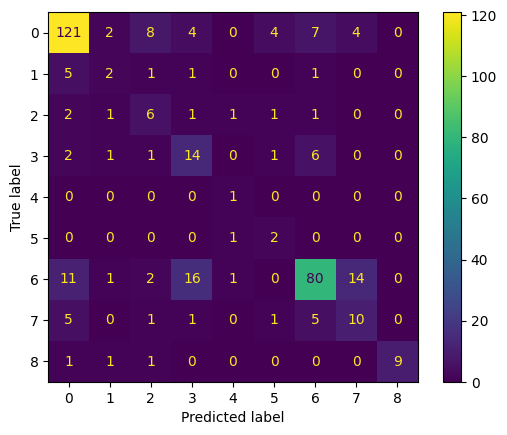

In [58]:
X = get_maccs_fps(df)
y = df.taste

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

X_resampled, y_resampled = balance_classes(X_train, y_train)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.05)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_resampled)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

## Pipeline draft

Classes distribution : [(0, 731), (1, 50), (2, 69), (3, 149), (4, 8), (5, 25), (6, 589), (7, 125), (8, 63)]
Classes distribution : [(0, 731), (1, 731), (2, 731), (3, 731), (4, 731), (5, 731), (6, 731), (7, 731), (8, 731)]
(6579, 167)
(6579, 114)
Classes distribution train: [(0, 598), (1, 582), (2, 586), (3, 560), (4, 577), (5, 591), (6, 604), (7, 583), (8, 582)]
Classes distribution test: [(0, 133), (1, 149), (2, 145), (3, 171), (4, 154), (5, 140), (6, 127), (7, 148), (8, 149)]
Balanced accuracy: 89.39%


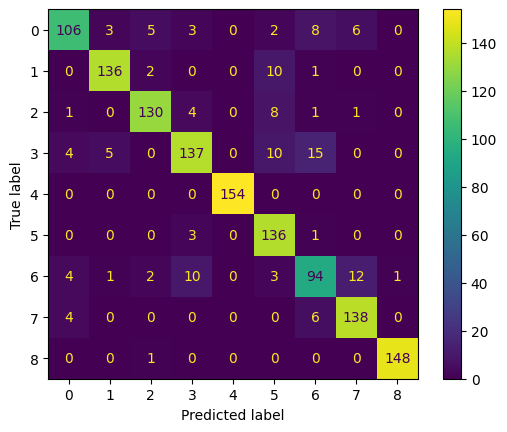

In [57]:
# 1) Zmień encoding
# ecfp_fp = ECFPFingerprint() #zmień rozmiar fingerprinta MACCS
# X = ecfp_fp.transform(df.smiles)
# y = df.taste
X = get_maccs_fps(df)
y = df.taste

# 2) Zbalansuj klasy
X_resampled, y_resampled = balance_classes(X, y)

# 3) Wyselekcjonuj atrybuty
X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.05)
column_names = X_selected.columns

# 4) Train test split
X_train, X_test, y_train, y_test  = train_test_split_data(X_selected, y_resampled)

# 5) Train model
clf = train_model(X_train, y_train)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

## Model building

## Model training

## Making predictions

In [59]:
df = pd.read_csv('data/test.csv')
df.head()

,molecule_id,smiles
0,test_0,NC(=O)NN=Cc1ccc([N+](=O)[O-])o1
1,test_1,CCOC=O
2,test_2,CCOC(=O)C(Cc1c[nH]c2ccccc12)NC(=O)C1CCCN1C(=O)...
3,test_3,CC1=CCC(C(C)(C)OC(=O)c2ccccc2N)CC1
4,test_4,O=S(=O)([O-])Nc1nnc(-c2ccccc2Br)s1.[Na+]


In [60]:
# 1) Zmień encoding
# ecfp_fp = ECFPFingerprint() #zmień rozmiar fingerprinta MACCS
# X = ecfp_fp.transform(df.smiles)
# y = df.taste
maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in df['smiles']]
maccs_lists = [list(l) for l in maccs]
maccs_name = [f'MACCS_{i}' for i in range(167)]
X = pd.DataFrame(maccs_lists, index=df.index, columns=maccs_name)

# 3) Wyselekcjonuj atrybuty
X = X[column_names]

# 4) Predict
model_predictions = clf.predict(X)

# 5) Save results


In [61]:
import csv
csv_file_path = f'./results/results_model_04.csv'

with open(csv_file_path, mode='w', newline='') as file:
    
    writer = csv.writer(file)
    file.write('molecule_id' + ',' + 'taste' + '\n')
    
    for i, pred in enumerate(model_predictions):
        file.write('test_' + str(i) + ',' + str(pred) + '\n')

print(f"CSV file '{csv_file_path}' created successfully!!!")

CSV file './results/results_model_04.csv' created successfully!!!


## Visualising results
